# "Agrupamiento k-Means para CIFAR-10"
> Agrupamiento (clustering) basado en k-Means para CIFAR-10.


- toc: true 
- badges: true 
- comments: true
- categories: ["Computer Vision"]
- image: images/stanford.png



## 1. Introducción

Este ejemplo muestra cómo hacer un agrupamiento (clustering) para el dataset de de imágenes de Cifar-10. Nótese que esto no es un problema de clasificación, sino un clustering con un tipo de entrenamiento NO supervisado.

Diferencias entre clasificación y agrupamiento ó clustering:
* En la **clasificación**, las clases resultantes son dadas como parte del set de entrenamiento. Esta información es realmente usada durante el entrenamiento apra construir el clasificador. Posteriormente, se aplica el clasificador resultante sobre imágenes nuevas (sin clasificar previamente).  
* En el **agrupamiento**, se particionan las imágenes en varios grupos (clases resultantes). No se conoce el significado de esas clases,simplemente se sabe que estadísticamente son parecidas.
Ejemplos de redes para clasificación es una red convolucional (aprendizaje supervisado). Ejemplo de algoritmos de agrupamiento es kMeans.

En este notebook se va a usar k-Means, que es un **algoritmo de clasificación no supervisado** (clustering) que agrupa objetos en k grupos basándose en sus características. El clustering in k grupos se realiza minimizando la suma de distancias (puede ser media ó cuadrática) entre cada objeto y el centroide de su cluster.

Este ejemplo se ha probado y funciona en Colab.

## 2. Setup
Importamos las librerías que vamos a usar. Usaremos la función experimental `tensorflow.numpy` para aprovechar las GPUs durante operaciones con funciones `numpy` (por ejemplo, durante la inferencia):

In [ ]:
!pip3 install -U --quiet --upgrade tf-nightly
!pip3 install -U scikit-learn


In [2]:
import matplotlib.pyplot as plt

import tensorflow as tf
import numpy as np
from sklearn.utils import shuffle

from tensorflow.keras import datasets, layers, models

Comprobamos si tenemos GPUs. En caso contrario, no notaremos diferencia de velocidad:

In [3]:
print("All logical devices:", tf.config.list_logical_devices())
print("All physical devices:", tf.config.list_physical_devices())
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

All logical devices: [LogicalDevice(name='/device:CPU:0', device_type='CPU'), LogicalDevice(name='/device:XLA_CPU:0', device_type='XLA_CPU')]
All physical devices: [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:XLA_CPU:0', device_type='XLA_CPU')]
Num GPUs Available:  0


## 3. Carga de datos
Cargamos el dataset desde `tensorflow.keras.datasets`:

In [4]:
(train_images, train_labels), (test_images, test_labels) = datasets.cifar10.load_data()

# Usando scikit-learn, Hacemos shuffle y usamos sólo 2000 imágenes para entrenar y 100 para test
train_images, train_labels = shuffle(train_images, train_labels)
test_images, test_labels = shuffle(test_images, test_labels)

train_images = train_images[:2000]
train_labels = train_labels[:2000]
test_images = test_images[:100]
test_labels = test_labels[:100]

# Normalizamos valores de píxeles entre 0 y 1
train_images, test_images = train_images / 255.0, test_images / 255.


Visualizamos los primeros 25 elementos del dataset:

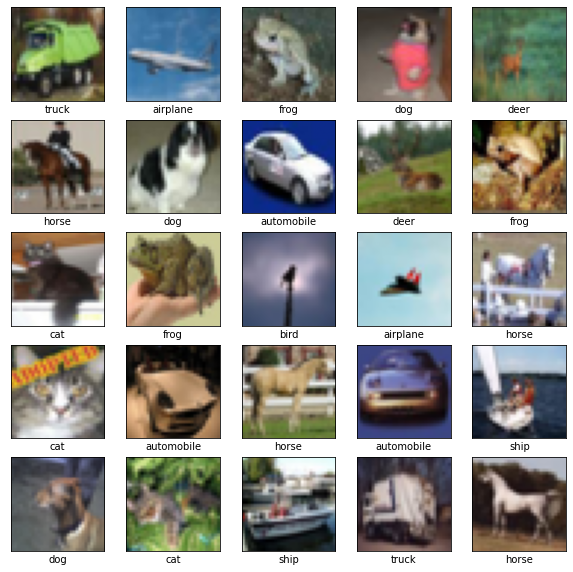

In [5]:
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']

plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_images[i], cmap=plt.cm.binary)
    # The CIFAR labels happen to be arrays, 
    # which is why you need the extra index
    plt.xlabel(class_names[train_labels[i][0]])
plt.show()

## 4. Preparar datos
El set de entrenamiento original era de tamaño `train_images.shape=(50000,32,32,3)` y sus etiquetas `train_labels.shape=(50000, 1)`. Pero usamos uno más pequeño de 2000. Aplanamos el set de entrenamiento y también el de pruebas:

In [6]:
train_images_rows = train_images.reshape(train_images.shape[0], 32 * 32 * 3) # train_images_rows.shape 2000 x 3072
test_images_rows = test_images.reshape(test_images.shape[0], 32 * 32 * 3) # test_images_rows.shape 100 x 3072

## 5. Construcción del modelo


El algoritmo k-Means consta de tres pasos:

1. **Inicialización:** se selecciona el número de centroides (grupos, `NUM_CENTROIDS`) y se crean con el tamaño de las imágenes, aleatorios.  
2. **Asignación:** cada imagen es asignada a su centroide más cercano.  
3. **Actualización centroides:** se actualiza la posición del centroide de cada grupo tomando como nuevo centroide la posición del promedio de los objetos pertenecientes a dicho grupo.

Se repiten los pasos 2 y 3 hasta que los centroides están lo suficientemente cerca.

In [190]:
# Paso 1: Inicialización
NUM_IMAGES = train_images.shape[0] # 2000
NUM_CENTROIDS = 10 # We know number of centroids beforehand

# Paso 2: Asignación a centroide más cercano

def assignment(centroids):
  closest = []

  for j in range(NUM_IMAGES):
    distances_from_centroid = []
    for i in range(NUM_CENTROIDS):
      distances_from_centroid = np.append(distances_from_centroid, np.sum(np.abs(centroids[i, :] - train_images_rows[j,:])))
    #print(distances_from_centroid)
    closest.append(np.argmin(distances_from_centroid))
  #print(closest)
  return closest

# Paso 3: Actualización centroides
def update(closest):
  accuracy = []
  new_centroids = np.zeros((NUM_CENTROIDS, 32*32*3))
  for c in range(NUM_CENTROIDS):
    num = 0
    best = []
    # Takes all images assigned to the centroid and calculates average
    for i in range(NUM_IMAGES):
      if (closest[i] == c):
        num = num + 1
        #print(train_images_rows[i, :])
        new_centroids[c, :] += train_images_rows[i, :]
        best = np.append(best, train_labels[i])

    # Discard if there are no images (num=0) assigned to a centroid
    # Calculate average
    if (num>0):
      new_centroids[c, :] = new_centroids[c, :] / num

    # Calculate ACCURACY for each cluster separately
    # Note clusters do not follow label ordering of train images, so cluster 0 does not equal to label_0 (airplane)
    unique, counts = np.unique(best, return_counts=True)
    #print("Cluster ", c ," has ", num, " images assigned. Most frequent label is: ", unique[counts == counts.max()])
    #print(dict(zip(unique, counts)))
    wrong_label_count = 0
    # Fix case where two or more labels are the most frequent in a cluster simultaneously
    if (unique[counts == counts.max()].size > 1):
      best_label = unique[counts == counts.max()][0]
    else:
      best_label = unique[counts == counts.max()]
    for i in range(NUM_IMAGES):
        if (closest[i] == c):
            if (best_label != train_labels[i]):
                wrong_label_count += 1
    accuracy = np.append(accuracy, 1-wrong_label_count/num)
  return new_centroids, accuracy  


In [194]:
# Ejecución del algoritmo k-Means: bucle hasta que los centroides no cambian
centroides = np.random.rand(NUM_CENTROIDS, 32*32*3)
while True:
    cercanos = assignment(centroides)
    nuevos_centroides, precision = update(cercanos)
    print("Accuracy: ", precision.mean(), " Convergence: ", np.sum(nuevos_centroides)-np.sum(centroides))
    if (np.allclose(nuevos_centroides, centroides)):
      break
    centroides = nuevos_centroides



Accuracy:  0.20502322736993128  Convergence:  -591.3110580002704
Accuracy:  0.21085505472671584  Convergence:  259.93384793577206
Accuracy:  0.21752808820413705  Convergence:  108.06564756441549
Accuracy:  0.22049767698153871  Convergence:  46.33073509634414
Accuracy:  0.2259574664808496  Convergence:  13.287203727499218
Accuracy:  0.22377838923261292  Convergence:  -24.86049448992344
Accuracy:  0.21993763580205714  Convergence:  -23.192419253706248
Accuracy:  0.22212657749503176  Convergence:  -3.803863856532189
Accuracy:  0.21989185955046522  Convergence:  -9.37191741927927
Accuracy:  0.2194832540447229  Convergence:  -24.583435479549735
Accuracy:  0.21945011595237224  Convergence:  -23.353119802255605
Accuracy:  0.22286533652569251  Convergence:  -18.956181842979277
Accuracy:  0.22116038576308544  Convergence:  -9.240914125522977
Accuracy:  0.21823313256558627  Convergence:  -4.384345563248644
Accuracy:  0.22041980164769584  Convergence:  -9.953124988762283
Accuracy:  0.222108961074

En el paso 2 anterior (asignación de centroides), se puede usar la distancia L1 ó L2 (cuadrática). Para la diferencia cuadrática, simplemente cambiar la línea  por la siguiente:
`distances_from_centroid.append(np.sqrt(np.sum(np.abs(centroids[i, :] - train_images_rows[j,:]))))`

## 6. Evaluación
La precisión la obtuvimos en el paso anterior. Cada cluster no sigue el orden de las etiquetas  del dataset, es decir, el cluster 0 no corresponde a la clase `airplane`. Mostramos las 25 primeras imágenes del **Cluster 0**, aunque esto no es representativo ya que la precisión es baja y no estamos viendo todas las imágenes del cluster 0:

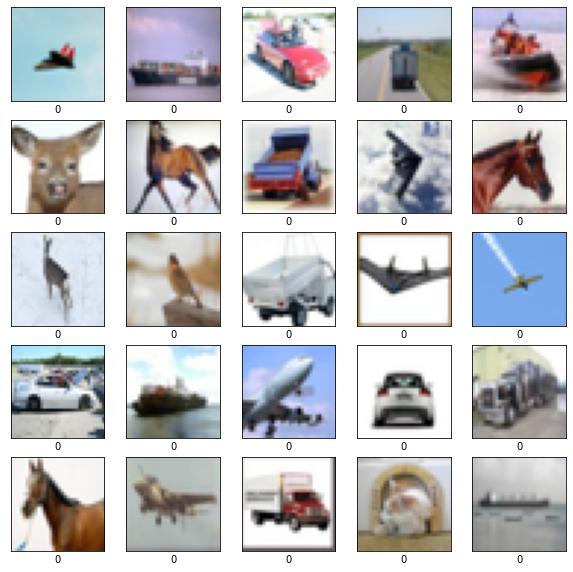

In [188]:
CENTROID_TO_EVALUATE = 0 # Cluster a mostrar
train_images_rows_img = train_images_rows.reshape(train_images_rows.shape[0], 32, 32, 3)

plt.figure(figsize=(10,10))
num = 0
for i in range(NUM_IMAGES):
    if (num == 25):
        break
    if (cercanos[i] == CENTROID_TO_EVALUATE):
        plt.subplot(5,5,num+1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow(train_images_rows_img[i], cmap=plt.cm.binary)
        plt.xlabel(cercanos[i])
        num += 1

Como curiosidad, vemos los 10 centroides generados y mostramos sus imágenes:



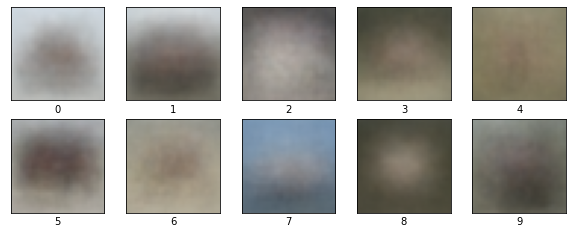

In [189]:
centroides_img = nuevos_centroides.reshape(nuevos_centroides.shape[0], 32, 32, 3)

plt.figure(figsize=(10,10))
for c in range(NUM_CENTROIDS):
    plt.subplot(5,5,c+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(centroides_img[c], cmap=plt.cm.binary)
    # The CIFAR labels happen to be arrays, 
    # which is why you need the extra index
    plt.xlabel(c)
plt.show()